In [1]:
import torch    
torch.manual_seed(123)
import random
random.seed(123)

import config

import torch.nn as nn
import os
import shutil
import itertools

from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade
from chofer_tda_datasets import Reddit5kJmlr
from chofer_tda_datasets.transforms import Hdf5GroupToDict
from jmlr_2018_code.utils import *
from sklearn.model_selection import ShuffleSplit

from chofer_torchex.nn.slayer import SLayerRationalHat, LinearRationalStretchedBirthLifeTimeCoordinateTransform, prepare_batch


from collections import Counter, defaultdict

%matplotlib notebook



from torch.utils.data import DataLoader, SubsetRandomSampler

os.environ['CUDA_VISIBLE_DEVICES'] = str(1)

class RedditCollate:   
    def __init__(self, dataset, cuda=True):
        self.cuda = cuda
        self.dataset = dataset
        
    def __call__(self, sample_target_iter):
        x, y = dict_sample_target_iter_concat(sample_target_iter)
        
        for k in self.dataset.keys_not_essential:
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 2)
            
        for k in self.dataset.keys_essential:
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 1)            

        y = torch.LongTensor(y)    

        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

            y = y.cuda()

        return x, y
    

class train_env:
    n_epochs = 300
    lr_initial = 0.5
    lr_epoch_step = 20
    batch_size = 100
    train_size = 0.9
    nu = 0.01
    momentum = 0.9


In [2]:
dataset = Reddit5kJmlr(data_root_folder_path=config.paths.data_root_dir)
dataset.keys_essential = ('dim_0_ess', 'dim_1_ess')
dataset.keys_not_essential = ('dim_0',)
dataset.keys_of_interrest = dataset.keys_essential + dataset.keys_not_essential

In [3]:
def unsqueeze_essentials(x):
    for k in dataset.keys_essential:
        if len(x[k]) > 0:
            x[k] = x[k].unsqueeze(1)
            
    return x

def coordinate_transform(x):
    t = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)
    for k in dataset.keys_not_essential:
        x[k] = t(x[k])   
        
    return x

dataset.data_transforms = \
[
    Hdf5GroupToDict(),
    numpy_to_torch_cascade,
    coordinate_transform, 
    unsqueeze_essentials
]
dataset.target_transforms = [lambda x: int(x) - 1]

In [4]:
reddit_collate = RedditCollate(dataset, cuda=False)         

In [5]:
def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU()
                     )
    m.out_features = m[0].out_features
    return m


def Slayer(n_elements, point_dim):
    return SLayerRationalHat(n_elements, point_dimension=2, radius_init=500)   


class Reddit5KModel(nn.Module):    
    def __init__(self):
        super().__init__()  
        
        dim_0_n_elements = 150
        dim_0_ess_n_elements = 5
        dim_1_ess_n_elements = 50
        
        self.dim_0 = nn.Sequential(
            Slayer(dim_0_n_elements, 2),
            nn.Tanh()
        )
        self.dim_0_ess = nn.Sequential(            
            Slayer(dim_0_ess_n_elements, 1),
            nn.Tanh()
        )
        self.dim_1_ess = nn.Sequential(            
            Slayer(dim_1_ess_n_elements, 1),
            nn.Tanh()
        )
        

        cls_in_size = dim_0_n_elements + dim_0_ess_n_elements + dim_1_ess_n_elements
        n_1 = 2*cls_in_size

        self.cls = nn.Sequential(          
                               nn.Dropout(0.2),
                               LinearCell(cls_in_size, n_1),
                               nn.Dropout(0.2),
                               LinearCell(n_1, int(n_1/4)),
                               LinearCell(int(n_1/4), int(n_1/16)),
                               nn.Linear(int(n_1/16), 5))
                         
    def forward(self, x):
        x_dim_0 = self.dim_0(x['dim_0'])        
        
        x_dim_0_ess = self.dim_0_ess(x['dim_0_ess'])   
        
        x_dim_1_ess = self.dim_1_ess(x['dim_1_ess'])       
        
        x = torch.cat([x_dim_0, x_dim_0_ess, x_dim_1_ess], dim=1)
        x = self.cls(x)
            
        return x
        
        
    def centers_init(self, sample_target_iter):
        x, _ = dict_sample_target_iter_concat(sample_target_iter)
        
        def get_centers(samples, n_centers):    
            s = torch.cat(samples, dim=0)
            s = list({tuple(row) for row in s})
            
            if len(s) < n_centers:
                while len(s) < n_centers:
                    s += s 
                    
            s = np.array(s)
            
            if s.ndim == 1:
                s = s.reshape(-1, 1)
                
            kmeans = sklearn.cluster.KMeans(n_clusters=n_centers, 
                                            init='k-means++', 
                                            random_state=123, 
                                            n_init=1)                           
            kmeans.fit(s)
            centers = kmeans.cluster_centers_
            centers = torch.from_numpy(centers).float()    
            return centers
        
        for key, slayer in zip(['dim_0', 'dim_0_ess', 'dim_1_ess'], [self.dim_0[0], self.dim_0_ess[0], self.dim_1_ess[0]]):
            samples = x[key]       
            
            centers = get_centers(samples, slayer.centers.size(0))
            slayer.centers.data = centers

In [6]:
def experiment(train_slayer): 
    
    stats_of_runs = []
    
    splitter = ShuffleSplit(n_splits=10, 
                            train_size=train_env.train_size, 
                            test_size=1-train_env.train_size, 
                            random_state=123)
    train_test_splits = list(splitter.split(X=dataset.targets, y=dataset.targets))

    train_test_splits = [(train_i.tolist(), test_i.tolist()) for train_i, test_i in train_test_splits]
    
    for run_i, (train_i, test_i) in enumerate(train_test_splits):
        print('')
        print('Run', run_i)
        
        model = Reddit5KModel()
        model.centers_init([dataset[i] for i in train_i])
        model.cuda()

        stats = defaultdict(list)
        stats_of_runs.append(stats)  
        
        stats['model'] = model        
        
        opt=torch.optim.SGD(model.parameters() if train_slayer else model.cls.parameters(), 
                            lr=train_env.lr_initial,
                            momentum=train_env.momentum)

        for i_epoch in range(1, train_env.n_epochs+1):      

            model.train()
            
            dl_train = DataLoader(dataset,
                              batch_size=train_env.batch_size, 
                              collate_fn=reddit_collate,
                              sampler=SubsetRandomSampler(train_i),                               
                              num_workers=5,
                              drop_last=True)

            dl_test = DataLoader(dataset,
                                 batch_size=train_env.batch_size, 
                                 collate_fn=reddit_collate, 
                                 sampler=SubsetRandomSampler(test_i),
                                 num_workers=5)

            epoch_loss = 0

            if i_epoch % train_env.lr_epoch_step == 0:
                adapt_lr(opt, lambda lr: lr*0.5)

            for i_batch, (x, y) in enumerate(dl_train, 1):   
                
                x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                     for k, v in x.items()}

                y = y.cuda()

                y = torch.autograd.Variable(y)

                def closure():
                    opt.zero_grad()
                    y_hat = model(x)            
                    loss = nn.functional.cross_entropy(y_hat, y)   
                    loss.backward()
                    return loss

                loss = opt.step(closure)

                epoch_loss += float(loss)
                stats['loss_by_batch'].append(float(loss))
                stats['centers'].append(model.dim_0[0].centers.data.cpu().numpy())
                stats['radius'].append(model.dim_0[0].radius.data.cpu().numpy())

                print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="     \r")

            stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))

            model.eval()    
            true_samples = 0
            seen_samples = 0
            epoch_test_loss = 0
            for i_batch, (x, y) in enumerate(dl_test):
                
                x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

                y = y.cuda()

                y_hat = model(x)
                epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)

                y_hat = y_hat.max(dim=1)[1].data.long()

                true_samples += (y_hat == y).sum()
                seen_samples += y.size(0)  

            test_acc = true_samples.item()/seen_samples
            stats['test_accuracy'].append(test_acc)
            stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))      
        
    return stats_of_runs

In [7]:
res_trained_slayer = experiment(True)


Run 0
Epoch 300/300, Batch 44/44     
Run 1
Epoch 300/300, Batch 44/44     
Run 2
Epoch 300/300, Batch 44/44     
Run 3
Epoch 300/300, Batch 44/44     
Run 4
Epoch 300/300, Batch 44/44     
Run 5
Epoch 300/300, Batch 44/44     
Run 6
Epoch 300/300, Batch 44/44     
Run 7
Epoch 300/300, Batch 44/44     
Run 8
Epoch 300/300, Batch 44/44     
Run 9


In [8]:
accs = [np.mean(s['test_accuracy'][-10:]) for s in res_trained_slayer]
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.5618000000000001, 0.5364000000000001, 0.5264, 0.5642, 0.5542, 0.5831999999999999, 0.5370000000000001, 0.5584, 0.5424, 0.5236]
0.54876
0.017836995262655638


In [9]:
res_rigid_slayer = experiment(False)


Run 0
Epoch 300/300, Batch 44/44     
Run 1
Epoch 300/300, Batch 44/44     
Run 2
Epoch 300/300, Batch 44/44     
Run 3
Epoch 300/300, Batch 44/44     
Run 4
Epoch 300/300, Batch 44/44     
Run 5
Epoch 300/300, Batch 44/44     
Run 6
Epoch 300/300, Batch 44/44     
Run 7
Epoch 300/300, Batch 44/44     
Run 8
Epoch 300/300, Batch 44/44     
Run 9


In [10]:
accs = [np.mean(s['test_accuracy'][-10:]) for s in res_rigid_slayer]
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.5588, 0.5328, 0.5111999999999999, 0.5274000000000001, 0.5186, 0.5626, 0.5326000000000001, 0.5544, 0.5252000000000001, 0.5274000000000001]
0.5351000000000001
0.016619326099454212


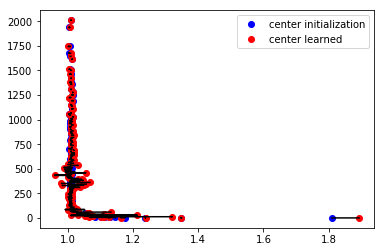

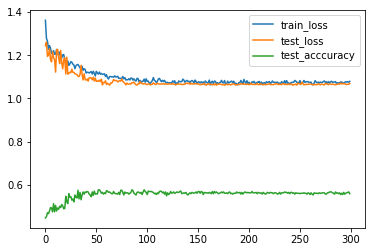

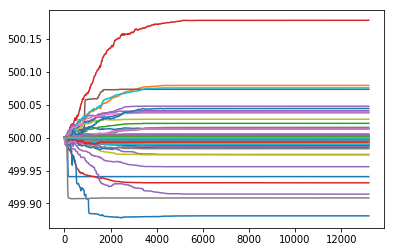

In [12]:
plt.figure()
stats = res_trained_slayer[0]

c_start = stats['centers'][3]
c_end = stats['centers'][-1]

plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

all_centers = numpy.stack(stats['centers'], axis=0)
for i in range(all_centers.shape[1]):
    points = all_centers[:,i, :]
    plt.plot(points[:, 0], points[:, 1], '-k')
    
plt.legend()

plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')
plt.plot(stats['test_accuracy'], label='test_acccuracy')
plt.legend()

plt.figure()
radius = stats['radius']
radius = np.stack(radius, axis=1)
for curve in radius:
    plt.plot(curve)
plt.show()

In [ ]:
dgm_len_by_label_dim_0 = defaultdict(list)
dgm_len_by_label_dim_1 = defaultdict(list)

for x, y in dataset:
    l_0 = x['dim_0'].shape[0]
    l_1 = len(x['dim_1_ess'])
    dgm_len_by_label_dim_0[y].append(l_0)
    dgm_len_by_label_dim_1[y].append(l_1)
    

In [ ]:
for k, v in sorted(dgm_len_by_label_dim_0.items(), key=lambda x: x[0]):
    plt.hist(v, label=str(k), alpha=0.5)
plt.legend()

In [ ]:
for k, v in sorted(dgm_len_by_label_dim_1.items(), key=lambda x: x[0]):
    plt.hist(v, label=str(k), alpha=0.5)
plt.legend()